In [ ]:
import numpy as np
import scipy.signal
import scipy.linalg
from scipy.linalg import toeplitz


# Подробное обоснование корректности

Пусть мы хотим минимизировать ошибку сжатия под действием линейного слоя на одномерный вектор. Будем уменьшать математическое ожидание квадрата нормы $E_{y}||y-y_{compr}||_2^2$

Пусть  $W- C_k=P$, где $P$ – матрица ошибок сжатия,  – сжатая матрица, $x$ – 1*m вектор, тогда:
$E_{y}||y-y_{compr}||_2^2=E_{x}||x(W-C_{compr})||_2^2=E_x||xP||_2^2=E_x(\sum_{i=1}^m\sum_{j=1}^m x_i x_j p_i p_j^T)$ , по определению matmul. Это выражение можно представить в виде поэлементного произведения:

$E_y||y-y_{compr}||_2^2=E_x(e \cdot ((x^Tx))\odot(PP^T)e^T)$, где e – вектор-строка из единиц, а  – поэлементное умножение. По свойствам поэлементного умножения и следа:
$E_y||y-y_{compr}||_2^2 = E_x(Tr((x^Tx)(PP^T)^T))=Tr(E_x(x^Tx)PP^T)=Tr(R_{XX}PP^T)$


$E_y||y-y_{compr}||_2^2 = E_x(Tr((x^Tx)(PP^T)^T))=||R_{XX}^{\frac{1}{2}}P||_F^2$


Поскольку $R_{XX}$, $PP^T$,  – симметрические положительные полуопределённые матрицы, можно извлечь корень и применить следующее преобразование:
$E_y||y-y_{compr}||_2^2=Tr(R_{XX}^{\frac{1}{2}}PP^T(R_{XX}^{\frac{1}{2}})^T)=||R_{XX}^{\frac{1}{2}}P||_F^2=arg \min||R_{XX}^{\frac{1}{2}}(W-C_k)||_F^2$

Сделаем замену  $Q=R_{XX}^{\frac{1}{2}}W,\ Q_C=R_{XX}^{\frac{1}{2}}C_k$ . Получаем:
$arg \min ||Q-Q_C||_F^2$

По т. Эккарта – Янга наилучшая малоранговая аппроксимация получается с помощью SVD разложения, тогда с учетом свойства нормы запишем:
$C_k = (R_{XX}^{\frac{1}{2}})^{-1}Q_C= (R_{XX}^{\frac{1}{2}})^{-1} U_{:,:k} \Sigma_{:k,:k} V_{:k,:}^*$ , где $U\Sigma V^* = SVD(Q)$

# Код для получения SVD с ACM

In [ ]:
rng = np.random.default_rng()
w = 5000
l = 2000
X = rng.random((w,l))
x = rng.random((w))

Получаем Тёплицеву матрицу

In [ ]:
ln = 2 * x.shape[0] - 1
Rxx = np.convolve(x,np.conj(x)[::-1])[ln//2 : ]
Rx = toeplitz(Rxx,np.hstack((Rxx[0],Rxx[1:])))


Обычное SVD разложение

In [ ]:
U, S, V = np.linalg.svd(X)
W_c = U[:,:w//5] * S[None, :w//5] @ V[:w//5,:]

Извлечение корня и обращение

In [ ]:
# используя разложение Шура
def schur(Rx, w, div=5):
  R_sq = scipy.linalg.sqrtm(Rx)
  R_fract_inv = np.linalg.inv(R_sq)
  Q = R_sq @ X
  U, S, V = np.linalg.svd(Q)
  Q_c = R_fract_inv @ U[:,:w//div] * S[None, :w//div] @ V[:w//div,:]
  return Q_c

In [ ]:
# используя с.з
def eig(Rx, w, div=5):
  vals, vec = np.linalg.eig(Rx)
  R_sq = vec*np.power(vals, 0.5)[None:]@vec.T
  R_fract_inv = vec*np.power(vals, -0.5)[None:]@vec.T
  Q = R_sq @ X
  U, S, V = np.linalg.svd(Q)
  Q_c = R_fract_inv @ U[:,:w//div] * S[None, :w//div] @ V[:w//div,:]
  return Q_c

Проверяем качество сжатия

In [ ]:
Q_c = schur()
# Q_c = eig()
Q_c

In [ ]:
# проверяем модифицированное разложение
np.linalg.norm(x@Q_c - x@X)

In [ ]:
# сравниваем со стандартным
np.linalg.norm(x@W_c - x@X)

# Тестирование скорости извлечения корня и обращения

In [ ]:
from time import perf_counter
import matplotlib.pyplot as plt

In [ ]:
schur_realis = []
eing_realis = []
schur_Q_list = []
eing_Q_list = []
schur_realis_min = []
eing_realis_min = []
schur_realis_max = []
eing_realis_max = []

N = 200
repeats = 10
rng = np.random.default_rng()

for shape in range(1000, 1601, N):
    print(shape)
    X = rng.random((shape, shape))
    x = rng.random((shape))
    ln = 2 * x.shape[0] - 1
    Rxx = np.convolve(x,np.conj(x)[::-1])[ln//2 : ]
    Rx = toeplitz(Rxx,np.hstack((Rxx[0],Rxx[1:])))
    for method, method_final_list, Q_list, max_list, min_list in zip(
        [eig, schur,],
        [schur_realis, eing_realis,],
        [schur_Q_list, eing_Q_list,],
        [schur_realis_max, eing_realis_max,],
        [schur_realis_min, eing_realis_min,],
    ):
        method_list = np.empty(repeats)
        for attempt in range(repeats):
            t_start = perf_counter()
            Q_list.append(method(Rx, shape))
            method_list[attempt] = perf_counter() - t_start
        perf = np.mean(method_list)
        method_final_list.append(perf)
        max_list.append(np.max(perf))
        min_list.append(np.min(perf))


1000
1200
1400
1600


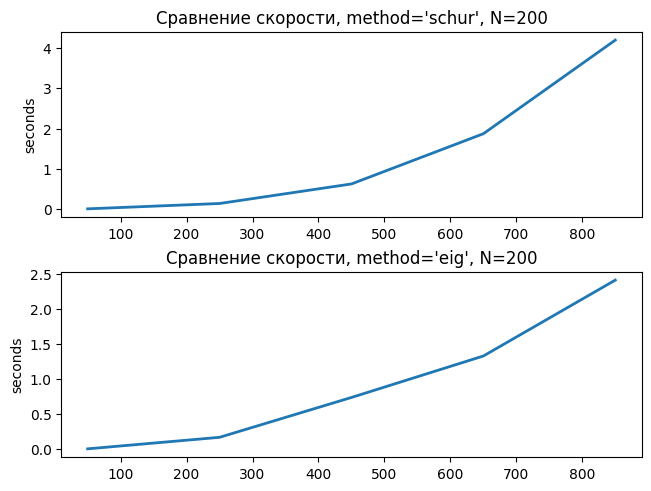

number of repeats for each array -  10


In [ ]:
fig, ax = plt.subplot_mosaic([
    ['schur'], ['eig']
], layout='constrained')

for method, mean, min, max in zip(['schur', 'eig'],
                                  [schur_realis, eing_realis],
                                  [schur_realis_min, eing_realis_min],
                                  [schur_realis_max, eing_realis_max]):
  ax[method].fill_between(range(50, 1001, N), min, max, alpha=.5, linewidth=0)
  ax[method].plot(range(50, 1001, N), mean, linewidth=2)
  ax[method].set_title(f'Сравнение скорости, {method=}, {N=}')
  ax[method].set_ylabel('seconds')


plt.show()
print('number of repeats for each array - ', repeats)

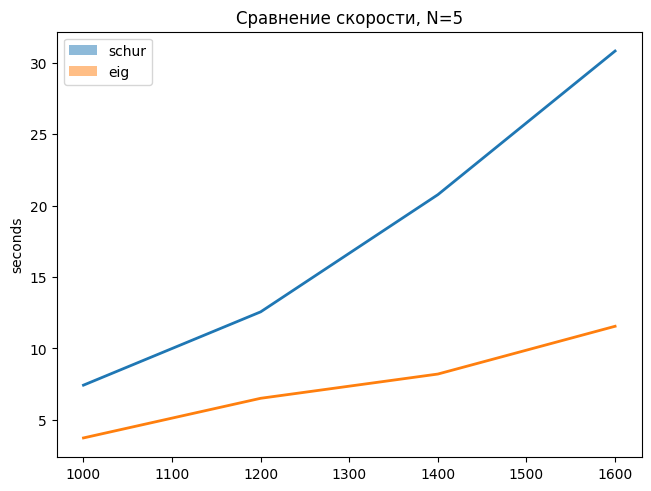

number of repeats for each array -  10


In [ ]:
fig, ax = plt.subplot_mosaic([
    ['schur'],
], layout='constrained')

method='schur'
ax[method].fill_between(range(1000, 1601, N), schur_realis_min, schur_realis_max, alpha=.5, linewidth=0, label ='schur')
ax[method].plot(range(1000, 1601, N), schur_realis, linewidth=2)
ax[method].set_title(f'Сравнение скорости, N={1000//N}')
#
ax[method].fill_between(range(1000, 1601, N), eing_realis_min, eing_realis_max, alpha=.5, linewidth=0, label ='eig')
ax[method].plot(range(1000, 1601, N), eing_realis, linewidth=2)
ax[method].set_ylabel('seconds')

ax[method].legend()
plt.show()
print('number of repeats for each array - ', repeats)

# Сравнение умножений

In [ ]:
# используя разложение Шура (для больших матриц)
def schur(Rx, w, method, div=5):
  R_sq = scipy.linalg.sqrtm(Rx)
  R_fract_inv = np.linalg.inv(R_sq)
  Q = R_sq @ X
  U, S, V = np.linalg.svd(Q)
  if method == 'mul':
    Q_c = R_fract_inv @ U[:,:w//div] * S[None, :w//div] @ V[:w//div,:]
  else:
    Q_c = scipy.linalg.matmul_toeplitz((R_fract_inv[:,0],R_fract_inv[0,:]), U[:,:w//div]) * S[None, :w//div] @ V[:w//div,:]
  return Q_c

In [ ]:
schur_realis = []
eing_realis = []
schur_Q_list = []
eing_Q_list = []
schur_realis_min = []
eing_realis_min = []
schur_realis_max = []
eing_realis_max = []

div = 5
N = 100
repeats = 10
rng = np.random.default_rng()

for shape in range(100, 1001, N):
    print(shape)
    X = rng.random((shape, shape))
    U = rng.random((shape, shape))
    x = rng.random((shape))
    ln = 2 * x.shape[0] - 1
    Rxx = np.convolve(x,np.conj(x)[::-1])[ln//2 : ]
    R_fract_inv = toeplitz(Rxx,np.hstack((Rxx[0],Rxx[1:])))

    for method, method_final_list, max_list, min_list in zip(['mul', 'toeplitz'],
        [schur_realis, eing_realis,],
        [schur_realis_max, eing_realis_max,],
        [schur_realis_min, eing_realis_min,]):
      method_list = np.empty(repeats)
      for attempt in range(repeats):
          t_start = perf_counter()
          if method == 'mul':
            Q_c = R_fract_inv @ U[:,:shape//div]
          else:
            Q_c = scipy.linalg.matmul_toeplitz((R_fract_inv[:,0],R_fract_inv[0,:]), U[:,:shape//div])
          method_list[attempt] = perf_counter() - t_start
      perf = np.mean(method_list)
      method_final_list.append(perf)
      max_list.append(np.max(perf))
      min_list.append(np.min(perf))


100
200
300
400
500
600
700
800
900
1000


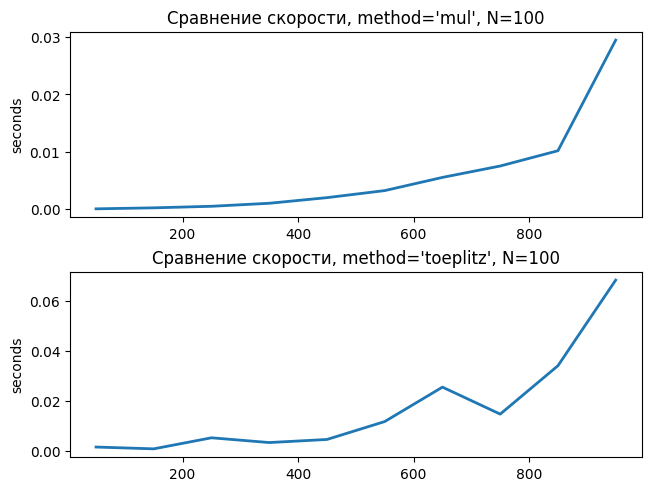

number of repeats for each array -  10


In [ ]:
fig, ax = plt.subplot_mosaic([
    ['mul'], ['toeplitz']
], layout='constrained')

for method, mean, min, max in zip(['mul', 'toeplitz'],
                                  [schur_realis, eing_realis],
                                  [schur_realis_min, eing_realis_min],
                                  [schur_realis_max, eing_realis_max]):
  ax[method].fill_between(range(50, 1001, N), min, max, alpha=.5, linewidth=0)
  ax[method].plot(range(50, 1001, N), mean, linewidth=2)
  ax[method].set_title(f'Сравнение скорости, {method=}, {N=}')
  ax[method].set_ylabel('seconds')


plt.show()
print('number of repeats for each array - ', repeats)

# Сравнение норм

In [ ]:
svd_list = []
acm_list = []

div = 5
N = 100
repeats = 10
rng = np.random.default_rng()

for shape in range(100, 1001, N):
    print(shape)
    X = rng.random((shape, shape))
    x = rng.random((shape))
    ln = 2 * x.shape[0] - 1
    Rxx = np.convolve(x,np.conj(x)[::-1])[ln//2 : ]
    Rx = toeplitz(Rxx,np.hstack((Rxx[0],Rxx[1:])))
    U, S, V = np.linalg.svd(X)
    W_c = U[:,:shape//5] * S[None, :shape//5] @ V[:shape//5,:]
    Q_c = eig(Rx, shape)
    acm_list.append(np.linalg.norm(x@Q_c - x@X))
    svd_list.append(np.linalg.norm(x@W_c - x@X))


100
200
300
400
500
600
700
800
900
1000


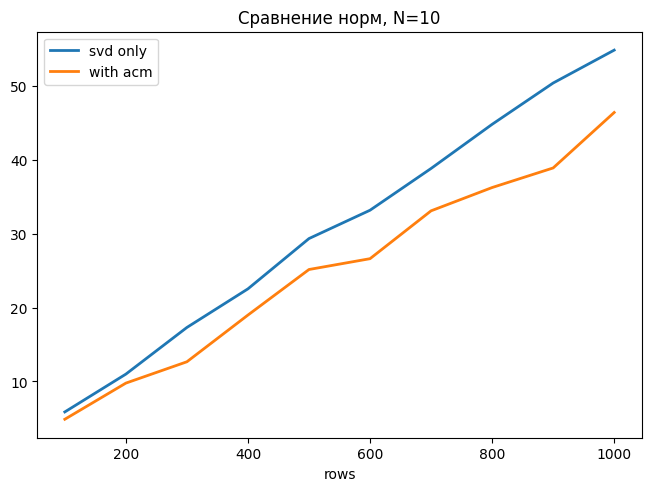

number of repeats for each array -  10


In [ ]:
fig, ax = plt.subplot_mosaic([
    ['schur'],
], layout='constrained')

method='schur'
ax[method].plot(range(100, 1001, N), acm_list, linewidth=2, label ='svd only')
ax[method].set_title(f'Сравнение норм, N={1000//N}')
ax[method].set_xlabel('rows')
#
ax[method].plot(range(100, 1001, N), svd_list, linewidth=2, label ='with acm')
ax[method].set_xlabel('rows')

ax[method].legend()
plt.show()
print('number of repeats for each array - ', repeats)

In [ ]:
# используя с.з (для матриц где-то до 100 строк)
def eig(Rx, w, compr):
  vals, vec = np.linalg.eig(Rx)
  R_sq = vec*np.power(vals, 0.5)[None:]@vec.T
  R_fract_inv = vec*np.power(vals, -0.5)[None:]@vec.T
  Q = R_sq @ X
  U, S, V = np.linalg.svd(Q)
  Q_c = R_fract_inv @ U[:,:compr] * S[None, :compr] @ V[:compr,:]
  return Q_c

In [ ]:
svd_list = []
acm_list = []

div = 5
N = 100
repeats = 10
shape = 500
rng = np.random.default_rng()
X = rng.random((shape, shape))
x = rng.random((shape))
ln = 2 * x.shape[0] - 1
Rxx = np.convolve(x,np.conj(x)[::-1])[ln//2 : ]
Rx = toeplitz(Rxx,np.hstack((Rxx[0],Rxx[1:])))
U, S, V = np.linalg.svd(X)

for compr in [shape // 10 * i for i in range(1,10)]:
    print(compr)
    W_c = U[:,:compr] * S[None, :compr] @ V[:compr,:]
    Q_c = eig(Rx, shape, compr)
    acm_list.append(np.linalg.norm(x@Q_c - x@X))
    svd_list.append(np.linalg.norm(x@W_c - x@X))


50
100
150
200
250
300
350
400
450


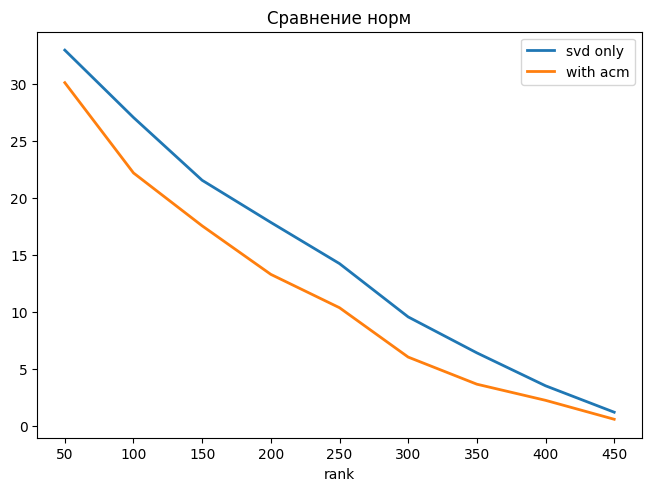

number of repeats for each array -  10


In [ ]:
fig, ax = plt.subplot_mosaic([
    ['schur'],
], layout='constrained')

method='schur'
ax[method].plot([shape // 10 * i for i in range(1,10)], svd_list, linewidth=2, label ='svd only')
ax[method].set_title(f'Сравнение норм')
ax[method].set_xlabel('rank')
#
ax[method].plot([shape // 10 * i for i in range(1,10)], acm_list, linewidth=2, label ='with acm')
ax[method].set_xlabel('rank')

ax[method].legend()
plt.show()
print('number of repeats for each array - ', repeats)